     tiempo_s  p1_bar  p2_bar  velf_m/s    F_m3/s    F_m3/h
225     450.0     2.0     1.0  0.689306  0.001397  5.029581
300     600.0     3.0     1.1  0.955915  0.001937  6.974920
500    1000.0     3.0     1.5  0.847630  0.001718  6.184808


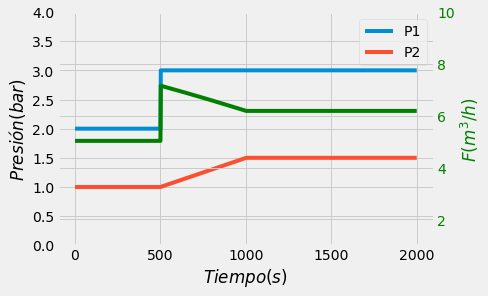

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
import pandas as pd
from scipy.optimize import newton
#from IPython.display impor display
from SPQentrada import *

#Datos iniciales
p1 = 2
p2 = 1
d_in1 = 1 
d_in2 = 2
L1 = 20
L2 = 30 
dt = 2

epsilon = 0.0001  #m
rho = 1000  #kg/m3
viscosidad = 0.001 #Kg/(m·s)

K_codo = 0.9 #codo 90º

#Datos Escalon P1
t0_e1= 500
A_e1 = 1

#Datos Escalon P2
t0_e2= 500
A_e2 = 0

#Datos Rampa P1
t0_r1 = 500
pend1 = 0
dt1 = 500

#Datos Rampa P2
t0_r2 = 500
pend2 = 0.001
dt2 = 500

#Datos ExpDecreciente P1
t0_exd1 = 500
tau1 = 100
A_exd1 = 0

#Datos ExpDecreciente P2
t0_exd2 = 500
tau2 = 100
A_exd2 = 0

#límites "y". Cambio de escala
escalapresion = (0,4)
escalaF = (1,10)
        

def ejercicio10():
    
    #conversión automática de datos
    
    
    d_m1 = d_in1 * 0.0254
    area1 = np.pi * d_m1**2 / 4
    epsi_d1 = epsilon/d_m1
    
    d_m2 = d_in2 * 0.0254
    area2 = np.pi * d_m2**2 / 4
    epsi_d2 = epsilon/d_m2
    
    K_ensan = (1 - area1 / area2)**2  #ensanchamiento brusco, A2 >> A1, 1 cabeza de velocidad

    def friccion_darcy(e_d, Re):
        """método de haaland"""
        if Re < 3000:
            friccion_darcy = 64 / Re
        else:
            A = (e_d/3.7)**1.1 + 6.9/Re
            friccion_darcy = 1 / (1.8 * np.log10(A))**2
        return friccion_darcy
    
    
    T = []
    P1 = []
    P2 = []
    V2 = []
    F = []

    for i in range(0,1001,1):
        t = i * dt
        T = np.append(T, t)
        p1t = p1 \
        + ESCALON(t0_e1, A_e1, t)\
        + RAMPA(t0_r1, pend1, dt1, t)\
        + ExpDecr(t0_exd1, tau1, A_exd1, t)
        P1 = np.append(P1, p1t)
    
        p2t = p2 \
        + ESCALON(t0_e2, A_e2, t)\
        + RAMPA(t0_r2, pend2, dt2, t)\
        + ExpDecr(t0_exd2, tau2, A_exd2, t)
        P2 = np.append(P2, p2t)
    
        p1_pascal = p1t * 100000
        p2_pascal = p2t * 100000
        
        def FOsolv (v2):
            
            v1 = v2* area2 / area1
            
            Re1 = rho * v1 * d_m1 / viscosidad
            Re2 = rho * v2 * d_m2 / viscosidad
        
            fd1 = friccion_darcy(epsi_d1, Re1)
            fd2 = friccion_darcy(epsi_d2, Re2)
            
            htotal = fd1 * (L1/d_m1) * (v1**2) / 2 \
            + fd2 * (L2/d_m2) * (v2**2) / 2 \
            + K_ensan * (v1**2) / 2 \
            + K_codo * (v1**2) / 2 \
            + K_codo * (v2**2) / 2 
            
            F0 = (p1_pascal - p2_pascal) / rho \
            + (v1**2 - v2**2)/ rho\
            - htotal  
            return F0
        
        #rho, viscosidad, d, e_d, L, p1_pascal, p2_pascal
        
        sol = newton(FOsolv, 1.5)
        v2 = sol
        
        #v = np.sqrt(cte_raiz / fd * (p1_pascal - p2_pascal))
        V2 = np.append(V2, v2)
    
        f = v2 * area2
        F = np. append(F, f)

    F_m3h= F * 3600

    #creacion de tabla df para pandas:
    valores = {'tiempo_s':T,
               'p1_bar':P1, 'p2_bar':P2,
               'velf_m/s':V2,
               'F_m3/s':F, 'F_m3/h':F_m3h}
    columnas = ['tiempo_s', 'p1_bar', 'p2_bar', 'velf_m/s', 'F_m3/s', 'F_m3/h']
    df = pd.DataFrame(valores, columns=columnas)

    #gráficos
    fig, ax1 = plt.subplots()

    ax1.plot(T, P1, label="P1")
    ax1.plot(T, P2, label="P2")
    ax1.set_xlabel('$Tiempo (s)$')
    ax1.set_ylabel('$Presión (bar)$')

    ax2 = ax1.twinx()
    ax2.plot(T, F_m3h, 'g-')
    ax2.set_ylabel('$F (m^3/h)$', color='g')
    ax2.tick_params('y', colors='g')

    #limites en y (Corrección de escala)
    ax1.set_ylim(escalapresion)
    ax2.set_ylim(escalaF)
    ax1.legend()

    tabla = df[(df.tiempo_s == 450) | (df.tiempo_s == 600) | (df.tiempo_s == 1000)]
    print (tabla)
    
ejercicio10()

Buscar un valor específico

     tiempo_s  p1_bar  p2_bar  velf_m/s    F_m3/s    F_m3/h
225     450.0     2.0     1.0   0.69006  0.001399  5.035083
300     600.0     3.0     2.0   0.69006  0.001399  5.035083
500    1000.0     7.0     6.0   0.69006  0.001399  5.035083


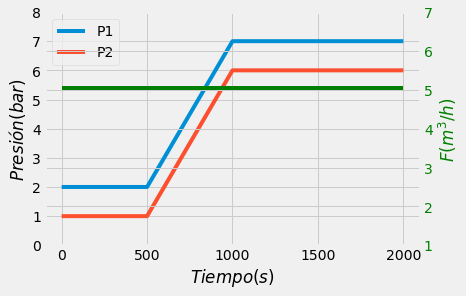

In [2]:
#Datos iniciales
p1 = 2
p2 = 1
d_in1 = 1 
d_in2 = 2
L1 = 20
L2 = 30 
dt = 2

epsilon = 0.0001  #m
rho = 1000  #kg/m3
viscosidad = 0.001 #Kg/(m·s)

K_codo = 0.9 #codo 90º

#Datos Escalon P1
t0_e1= 500
A_e1 = 0

#Datos Escalon P2
t0_e2= 500
A_e2 = 0

#Datos Rampa P1
t0_r1 = 500
pend1 = 5/500
dt1 = 500

#Datos Rampa P2
t0_r2 = 500
pend2 = 5/500
dt2 = 500

#Datos ExpDecreciente P1
t0_exd1 = 500
tau1 = 100
A_exd1 = 0

#Datos ExpDecreciente P2
t0_exd2 = 500
tau2 = 100
A_exd2 = 0

#límites "y". Cambio de escala
escalapresion = (0,8)
escalaF = (1,7)

ejercicio10()

     tiempo_s  p1_bar  p2_bar  velf_m/s    F_m3/s     F_m3/h
225     450.0     2.0     1.0  0.690060  0.001399   5.035083
300     600.0     3.0     1.2  0.931029  0.001887   6.793336
500    1000.0     7.0     2.0  1.562313  0.003167  11.399556


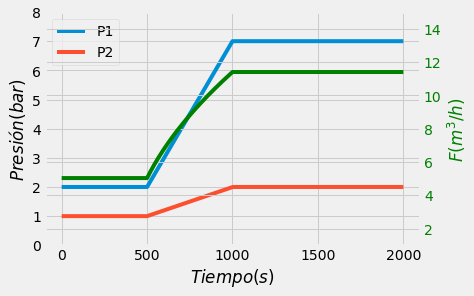

In [3]:
#Datos iniciales
p1 = 2
p2 = 1
d_in1 = 1 
d_in2 = 2
L1 = 20
L2 = 30 
dt = 2

epsilon = 0.0001  #m
rho = 1000  #kg/m3
viscosidad = 0.001 #Kg/(m·s)

K_codo = 0.9 #codo 90º

#Datos Escalon P1
t0_e1= 500
A_e1 = 0

#Datos Escalon P2
t0_e2= 500
A_e2 = 0

#Datos Rampa P1
t0_r1 = 500
pend1 = 5/500
dt1 = 500

#Datos Rampa P2
t0_r2 = 500
pend2 = 1/500
dt2 = 500

#Datos ExpDecreciente P1
t0_exd1 = 500
tau1 = 100
A_exd1 = 0

#Datos ExpDecreciente P2
t0_exd2 = 500
tau2 = 100
A_exd2 = 0

#límites "y". Cambio de escala
escalapresion = (0,8)
escalaF = (1,15)

ejercicio10()

     tiempo_s  p1_bar    p2_bar  velf_m/s    F_m3/s    F_m3/h
225     450.0     2.0  1.000000  0.690060  0.001399  5.035083
300     600.0     2.0  1.625799  0.416537  0.000844  3.039296
500    1000.0     2.0  1.983329  0.079736  0.000162  0.581799


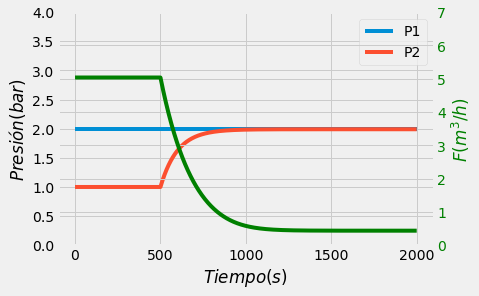

In [4]:
"""Con el A_exp2=1 no converge. Se modifica a A_exp2=0.99, 
es decir se deja un pequeño delta de presión"""

#Datos iniciales
p1 = 2
p2 = 1
d_in1 = 1 
d_in2 = 2
L1 = 20
L2 = 30 
dt = 2

epsilon = 0.0001  #m
rho = 1000  #kg/m3
viscosidad = 0.001 #Kg/(m·s)

K_codo = 0.9 #codo 90º

#Datos Escalon P1
t0_e1= 500
A_e1 = 0

#Datos Escalon P2
t0_e2= 500
A_e2 = 0

#Datos Rampa P1
t0_r1 = 500
pend1 = 0
dt1 = 500

#Datos Rampa P2
t0_r2 = 500
pend2 = 0
dt2 = 500

#Datos ExpDecreciente P1
t0_exd1 = 500
tau1 = 100
A_exd1 = 0

#Datos ExpDecreciente P2
t0_exd2 = 500
tau2 = 100
A_exd2 = 0.99

#límites "y". Cambio de escala
escalapresion = (0,4)
escalaF = (0,7)

ejercicio10()

     tiempo_s  p1_bar  p2_bar  velf_m/s    F_m3/s    F_m3/h
225     450.0     2.0     1.0  0.690060  0.001399  5.035083
300     600.0     3.0     1.0  0.982234  0.001991  7.166959
500    1000.0     7.0     4.0  1.206534  0.002445  8.803582


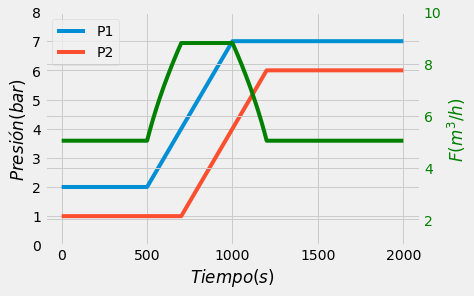

In [5]:
#Datos iniciales
p1 = 2
p2 = 1
d_in1 = 1 
d_in2 = 2
L1 = 20
L2 = 30 
dt = 2

epsilon = 0.0001  #m
rho = 1000  #kg/m3
viscosidad = 0.001 #Kg/(m·s)

K_codo = 0.9 #codo 90º

#Datos Escalon P1
t0_e1= 500
A_e1 = 0

#Datos Escalon P2
t0_e2= 500
A_e2 = 0

#Datos Rampa P1
t0_r1 = 500
pend1 = 5/500
dt1 = 500

#Datos Rampa P2
t0_r2 = 700
pend2 = 5/500
dt2 = 500

#Datos ExpDecreciente P1
t0_exd1 = 500
tau1 = 100
A_exd1 = 0

#Datos ExpDecreciente P2
t0_exd2 = 500
tau2 = 100
A_exd2 = 0

#límites "y". Cambio de escala
escalapresion = (0,8)
escalaF = (1,10)

ejercicio10()

     tiempo_s  p1_bar  p2_bar  velf_m/s    F_m3/s    F_m3/h
225     450.0     2.0     1.0  0.690060  0.001399  5.035083
300     600.0     3.0     1.1  0.956968  0.001940  6.982603
500    1000.0     2.6     1.5  0.724475  0.001468  5.286199


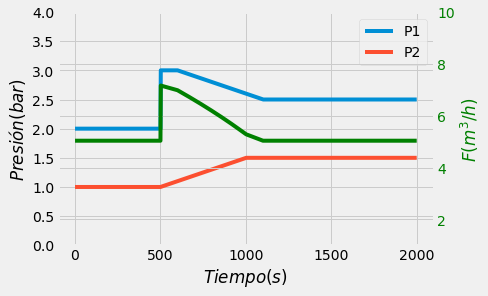

In [6]:
#Datos iniciales
p1 = 2
p2 = 1
d_in1 = 1 
d_in2 = 2
L1 = 20
L2 = 30 
dt = 2

epsilon = 0.0001  #m
rho = 1000  #kg/m3
viscosidad = 0.001 #Kg/(m·s)

K_codo = 0.9 #codo 90º

#Datos Escalon P1
t0_e1= 500
A_e1 = 1

#Datos Escalon P2
t0_e2= 500
A_e2 = 0

#Datos Rampa P1
t0_r1 = 600
pend1 = -0.001
dt1 = 500

#Datos Rampa P2
t0_r2 = 500
pend2 = 0.001
dt2 = 500

#Datos ExpDecreciente P1
t0_exd1 = 500
tau1 = 100
A_exd1 = 0

#Datos ExpDecreciente P2
t0_exd2 = 500
tau2 = 100
A_exd2 = 0

#límites "y". Cambio de escala
escalapresion = (0,4)
escalaF = (1,10)

ejercicio10()